In [1]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import BertTokenizer, Trainer, TrainingArguments
from transformers import BertForQuestionAnswering
from datasets import load_dataset
from sklearn.metrics import accuracy_score
import numpy as np
# from torchcrf import CRF
from tqdm import tqdm
from transformers import BertPreTrainedModel, BertModel

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [3]:
!pip uninstall -y wandb


Found existing installation: wandb 0.19.1
Uninstalling wandb-0.19.1:
  Successfully uninstalled wandb-0.19.1


In [4]:
pip install git+https://github.com/kmkurn/pytorch-crf.git


  Cloning https://github.com/kmkurn/pytorch-crf.git to /tmp/pip-req-build-3zwjot7v
  Running command git clone --filter=blob:none --quiet https://github.com/kmkurn/pytorch-crf.git /tmp/pip-req-build-3zwjot7v
  Resolved https://github.com/kmkurn/pytorch-crf.git to commit 623e3402d00a2728e99d6e8486010d67c754267b
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-crf: filename=pytorch_crf-0.7.2-py3-none-any.whl size=6410 sha256=d4c11caa3666a012027448405fcc9909ac4028b0673bbe202a43a9db6492b30a
  Stored in directory: /tmp/pip-ephem-wheel-cache-w906la2o/wheels/39/5f/f6/4b48b35895d914f4f5fff5b600f87658c11693e37b6a4f118e
Successfully built pytorch-crf
Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip uninstall -y torchcrf

In [6]:
!pip install torchcrf

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from datasets import load_dataset

class SquadDataset(Dataset):
    """
    Custom Dataset for SQuAD v2 that tokenizes the context/question pair.
    """
    def __init__(self, tokenizer, split="train", num_samples=15000, max_length=384, doc_stride=128):
        self.dataset = load_dataset("squad_v2", split=split)
        self.dataset = self.dataset.select(range(num_samples))
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.doc_stride = doc_stride

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        question = data["question"]
        context = data["context"]
        answers = data["answers"]
        if len(answers["text"]) > 0:
            answer_text = answers["text"][0]
            answer_start = answers["answer_start"][0]
        else:
            answer_text = ""
            answer_start = -1

        encoding = self.tokenizer(
            question,
            context,
            truncation="only_second",
            max_length=self.max_length,
            stride=self.doc_stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding="max_length",
        )
        input_ids = encoding["input_ids"][0]
        attention_mask = encoding["attention_mask"][0]
        offset_mapping = encoding["offset_mapping"][0]

        if answer_start == -1:
            start_position = 0
            end_position = 0
        else:
            end_char = answer_start + len(answer_text)
            token_start_index, token_end_index = 0, len(input_ids) - 1
            for i, (start, end) in enumerate(offset_mapping):
                if start <= answer_start < end:
                    token_start_index = i
                if start < end_char <= end:
                    token_end_index = i
                    break
            start_position = token_start_index
            end_position = token_end_index

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "start_positions": torch.tensor(start_position, dtype=torch.long),
            "end_positions": torch.tensor(end_position, dtype=torch.long),
        }

# Initialize tokenizer and create datasets
tokenizer = AutoTokenizer.from_pretrained("SpanBERT/spanbert-base-cased")
train_dataset = SquadDataset(tokenizer, split="train", num_samples=15000)
val_dataset = SquadDataset(tokenizer, split="validation", num_samples=1000)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8)


config.json:   0%|          | 0.00/413 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [8]:
import torch
from transformers import AutoModelForQuestionAnswering, AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F

# Set device to cuda:1 if available
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Load SpanBERT for question answering
model_spanbert = AutoModelForQuestionAnswering.from_pretrained("SpanBERT/spanbert-base-cased")
model_spanbert.to(device)

# Initialize optimizer and scheduler
optimizer = AdamW(model_spanbert.parameters(), lr=3e-5)
epochs = 6
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)

# Lists to record loss for plotting
train_losses = []
val_losses = []

for epoch in range(epochs):
    model_spanbert.train()
    total_train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        start_positions = batch["start_positions"].to(device)
        end_positions = batch["end_positions"].to(device)

        outputs = model_spanbert(input_ids=input_ids,
                                 attention_mask=attention_mask,
                                 start_positions=start_positions,
                                 end_positions=end_positions)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Improved SpanBERT Epoch {epoch+1}/{epochs} - Training Loss: {avg_train_loss:.4f}")

    # Validation loop
    model_spanbert.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            start_positions = batch["start_positions"].to(device)
            end_positions = batch["end_positions"].to(device)
            outputs = model_spanbert(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     start_positions=start_positions,
                                     end_positions=end_positions)
            total_val_loss += outputs.loss.item()
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Improved SpanBERT Epoch {epoch+1}/{epochs} - Validation Loss: {avg_val_loss:.4f}")

# Save the improved SpanBERT model
model_spanbert.save_pretrained("./improved_spanbert_qa_model")


pytorch_model.bin:   0%|          | 0.00/215M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Improved SpanBERT Epoch 1/6 - Training Loss: 2.8861
Improved SpanBERT Epoch 1/6 - Validation Loss: 2.3397
Improved SpanBERT Epoch 2/6 - Training Loss: 1.4490
Improved SpanBERT Epoch 2/6 - Validation Loss: 1.9252
Improved SpanBERT Epoch 3/6 - Training Loss: 1.0620
Improved SpanBERT Epoch 3/6 - Validation Loss: 2.1395
Improved SpanBERT Epoch 4/6 - Training Loss: 0.8220
Improved SpanBERT Epoch 4/6 - Validation Loss: 2.3001
Improved SpanBERT Epoch 5/6 - Training Loss: 0.6641
Improved SpanBERT Epoch 5/6 - Validation Loss: 2.5130
Improved SpanBERT Epoch 6/6 - Training Loss: 0.5653
Improved SpanBERT Epoch 6/6 - Validation Loss: 2.7698


IMproved spanbertcrf for better resilts 

In [9]:
import torch.nn as nn
from transformers import AutoModel, AdamW, get_linear_schedule_with_warmup
from torchcrf import CRF

class ImprovedSpanBERTCRFForQuestionAnswering(nn.Module):
    """
    Improved model that wraps SpanBERT with a CRF layer using BIO tagging.
    Tags: 0 = Outside, 1 = B-ANS (beginning), 2 = I-ANS (inside).
    Incorporates dropout and a two-layer feed-forward network.
    """
    def __init__(self, pretrained_model_name, hidden_size=768, dropout_prob=0.1):
        super(ImprovedSpanBERTCRFForQuestionAnswering, self).__init__()
        self.spanbert = AutoModel.from_pretrained(pretrained_model_name)
        self.dropout = nn.Dropout(dropout_prob)
        # Two-layer feed-forward network before CRF
        self.ffn = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, 3)  # 3 tags for BIO
        )
        self.crf = CRF(num_tags=3, batch_first=True)

    def forward(self, input_ids, attention_mask, start_positions=None, end_positions=None):
        outputs = self.spanbert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # (batch_size, seq_length, hidden_size)
        sequence_output = self.dropout(sequence_output)
        emissions = self.ffn(sequence_output)  # (batch_size, seq_length, 3)

        if start_positions is not None and end_positions is not None:
            batch_size, seq_length, _ = emissions.size()
            gold_labels = torch.zeros((batch_size, seq_length), dtype=torch.long, device=emissions.device)
            for i in range(batch_size):
                # If answer exists, assign BIO labels:
                if start_positions[i] > 0 or end_positions[i] > 0:
                    gold_labels[i, start_positions[i]] = 1  # B tag
                    if end_positions[i] > start_positions[i]:
                        gold_labels[i, start_positions[i]+1:end_positions[i]+1] = 2  # I tags
            loss = -self.crf(emissions, gold_labels, mask=attention_mask.bool(), reduction='mean')
            return loss, emissions
        else:
            pred_tags = self.crf.decode(emissions, mask=attention_mask.bool())
            return pred_tags, emissions

# Initialize and send the CRF model to device
model_spanbert_crf = ImprovedSpanBERTCRFForQuestionAnswering("SpanBERT/spanbert-base-cased")
model_spanbert_crf.to(device)

optimizer_crf = AdamW(model_spanbert_crf.parameters(), lr=3e-5)
epochs = 6
total_steps_crf = len(train_dataloader) * epochs
scheduler_crf = get_linear_schedule_with_warmup(optimizer_crf, num_warmup_steps=int(0.1 * total_steps_crf), num_training_steps=total_steps_crf)

train_losses_crf = []
val_losses_crf = []

for epoch in range(epochs):
    model_spanbert_crf.train()
    total_train_loss = 0
    for batch in train_dataloader:
        optimizer_crf.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        start_positions = batch["start_positions"].to(device)
        end_positions = batch["end_positions"].to(device)
        
        loss, _ = model_spanbert_crf(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     start_positions=start_positions,
                                     end_positions=end_positions)
        loss.backward()
        optimizer_crf.step()
        scheduler_crf.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses_crf.append(avg_train_loss)
    print(f"Improved SpanBERT-CRF Epoch {epoch+1}/{epochs} - Training Loss: {avg_train_loss:.4f}")

    model_spanbert_crf.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            start_positions = batch["start_positions"].to(device)
            end_positions = batch["end_positions"].to(device)
            loss, _ = model_spanbert_crf(input_ids=input_ids,
                                         attention_mask=attention_mask,
                                         start_positions=start_positions,
                                         end_positions=end_positions)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses_crf.append(avg_val_loss)
    print(f"Improved SpanBERT-CRF Epoch {epoch+1}/{epochs} - Validation Loss: {avg_val_loss:.4f}")

# Save the improved CRF model weights
torch.save(model_spanbert_crf.state_dict(), "./improved_spanbert_crf_qa_model.pt")


Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Improved SpanBERT-CRF Epoch 1/6 - Training Loss: 30.8547
Improved SpanBERT-CRF Epoch 1/6 - Validation Loss: 9.2291
Improved SpanBERT-CRF Epoch 2/6 - Training Loss: 11.4313
Improved SpanBERT-CRF Epoch 2/6 - Validation Loss: 6.6701
Improved SpanBERT-CRF Epoch 3/6 - Training Loss: 8.1321
Improved SpanBERT-CRF Epoch 3/6 - Validation Loss: 6.0866
Improved SpanBERT-CRF Epoch 4/6 - Training Loss: 6.1707
Improved SpanBERT-CRF Epoch 4/6 - Validation Loss: 6.2455
Improved SpanBERT-CRF Epoch 5/6 - Training Loss: 4.6755
Improved SpanBERT-CRF Epoch 5/6 - Validation Loss: 6.6334
Improved SpanBERT-CRF Epoch 6/6 - Training Loss: 3.8440
Improved SpanBERT-CRF Epoch 6/6 - Validation Loss: 6.4134


In [10]:
def exact_match_score(predictions, references):
    """Calculates the percentage of predictions that exactly match the reference answers."""
    assert len(predictions) == len(references), "Lists must have the same length"
    matches = sum(p == r for p, r in zip(predictions, references))
    return matches / len(references) * 100  # Percentage

def f1_score(prediction, ground_truth):
    """Computes the F1 score based on token overlap between prediction and ground truth."""
    pred_tokens = prediction.split()
    truth_tokens = ground_truth.split()
    common = set(pred_tokens) & set(truth_tokens)
    if len(common) == 0:
        return 0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(truth_tokens)
    return 2 * precision * recall / (precision + recall)

def extract_answer_from_bio(input_ids, tags, tokenizer):
    """
    Extracts a contiguous answer span based on BIO tags.
    It searches for the first occurrence of a B tag (1) and then takes following I tags (2).
    """
    span_tokens = []
    in_span = False
    for token, tag in zip(input_ids, tags):
        if tag == 1:  # Begin tag
            span_tokens = [token]
            in_span = True
        elif tag == 2 and in_span:
            span_tokens.append(token)
        elif in_span:
            break
    if span_tokens:
        return tokenizer.decode(span_tokens, skip_special_tokens=True).strip()
    return ""

def evaluate_improved_model(model, dataloader, tokenizer, device, model_type="spanbert"):
    """
    Evaluates the model on the validation set.
    For "spanbert", uses argmax over start/end logits.
    For "spanbert_crf", decodes the BIO tag sequence and extracts the answer span.
    """
    model.eval()
    predictions = []
    references = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            if model_type == "spanbert":
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                start_logits = outputs.start_logits
                end_logits = outputs.end_logits
                for i in range(input_ids.size(0)):
                    start_index = torch.argmax(start_logits[i]).item()
                    end_index = torch.argmax(end_logits[i]).item()
                    pred_answer = tokenizer.decode(input_ids[i][start_index:end_index+1], skip_special_tokens=True)
                    predictions.append(pred_answer.strip())
            elif model_type == "spanbert_crf":
                pred_tags, _ = model(input_ids=input_ids, attention_mask=attention_mask)
                for i, tags in enumerate(pred_tags):
                    pred_answer = extract_answer_from_bio(input_ids[i].tolist(), tags, tokenizer)
                    predictions.append(pred_answer)
            
            # Decode the ground truth answer using start/end positions.
            for i in range(input_ids.size(0)):
                start_pos = batch["start_positions"][i].item()
                end_pos = batch["end_positions"][i].item()
                true_answer = tokenizer.decode(input_ids[i][start_pos:end_pos+1], skip_special_tokens=True)
                references.append(true_answer.strip())
    
    em = exact_match_score(predictions, references)
    f1 = sum(f1_score(p, r) for p, r in zip(predictions, references)) / len(predictions)
    return em, f1

# Evaluate improved SpanBERT
em_spanbert, f1_spanbert = evaluate_improved_model(model_spanbert, val_dataloader, tokenizer, device, model_type="spanbert")
print(f"Improved SpanBERT - Exact Match: {em_spanbert:.2f}%, F1 Score: {f1_spanbert:.2f}")

# Evaluate improved SpanBERT-CRF
em_spanbert_crf, f1_spanbert_crf = evaluate_improved_model(model_spanbert_crf, val_dataloader, tokenizer, device, model_type="spanbert_crf")
print(f"Improved SpanBERT-CRF - Exact Match: {em_spanbert_crf:.2f}%, F1 Score: {f1_spanbert_crf:.2f}")


Improved SpanBERT - Exact Match: 43.50%, F1 Score: 0.30
Improved SpanBERT-CRF - Exact Match: 53.90%, F1 Score: 0.24


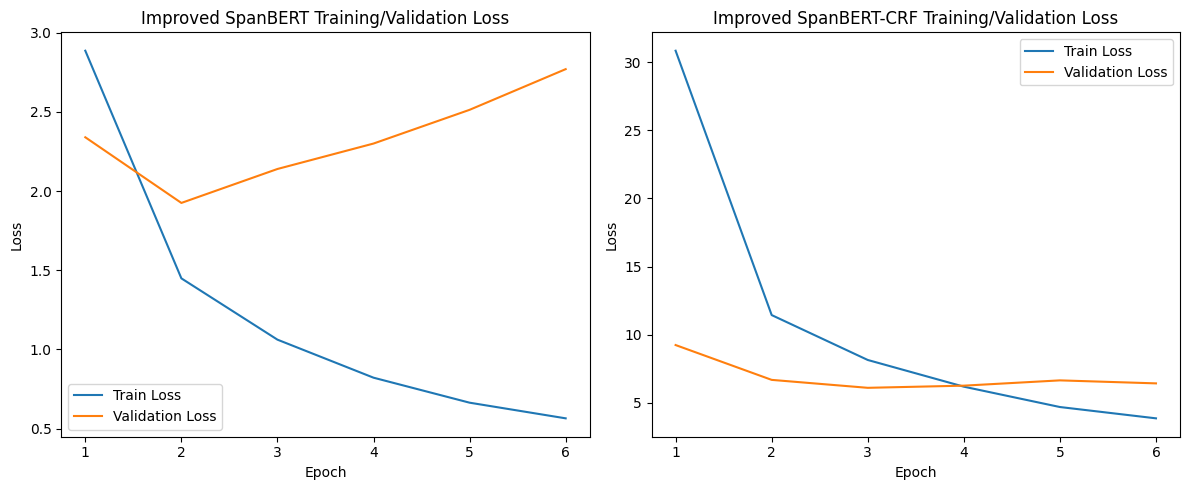

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot for Improved SpanBERT
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Improved SpanBERT Training/Validation Loss")
plt.legend()

# Plot for Improved SpanBERT-CRF
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_losses_crf, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses_crf, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Improved SpanBERT-CRF Training/Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# # THe above one is improved version of the code and below one task gave very bad reults 
# SpanBERT:
# Typically trains with a fixed learning rate (in the original version) or a scheduler (in the improved version).
# SpanBERT-CRF:
# Uses similar training hyperparameters but often requires extra tuning (e.g., dropout rate, learning rate scheduler, BIO tagging settings) to stabilize the CRF layer’s training.

SpanBERT (Baseline):

Fixed or Simple Scheduler: When using a fixed learning rate or a straightforward scheduler, the training updates are stable because the model only needs to learn to predict start and end logits independently.
Less Sensitivity: The model’s loss (cross-entropy for start/end positions) is computed for each token independently, so small fluctuations in hyperparameters have a moderate impact on convergence.
SpanBERT-CRF:

Extra Dependencies: The CRF layer learns dependencies across token labels, meaning that the output for each token is influenced by its neighbors. This creates a more complex loss surface.
Hyperparameter Sensitivity:
Dropout Rate: Needs careful tuning to prevent overfitting without losing too much signal in the sequential features.
Learning Rate Scheduler: A more finely tuned schedule (with warm-up and decay) is often necessary because the CRF’s sequential dependencies can be sensitive to abrupt changes in learning rate.
BIO Tagging Settings: Switching from binary to BIO tagging adds complexity, as the model now needs to correctly learn not only whether a token is part of an answer but also its position (beginning or inside)

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from datasets import load_dataset

class SquadDataset(Dataset):
    """
    Custom Dataset for SQuAD v2 that tokenizes the context/question pair.
    Uses a subset of the dataset. In addition to the tokenized inputs and answer span positions,
    this version returns a boolean flag 'has_answer' to indicate if an answer exists.
    """
    def __init__(self, tokenizer, split="train", num_samples=15000, max_length=384, doc_stride=128):
        self.dataset = load_dataset("squad_v2", split=split)
        # Select a subset for training/validation
        self.dataset = self.dataset.select(range(num_samples))
        print(f"{split.capitalize()} dataset loaded with {len(self.dataset)} samples.")
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.doc_stride = doc_stride

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Print progress every 100 samples
        if idx % 100 == 0:
            print(f"Processing sample index: {idx}")
            
        data = self.dataset[idx]
        question = data["question"]
        context = data["context"]
        answers = data["answers"]
        
        # Determine if the sample has a valid answer.
        if len(answers["text"]) > 0:
            answer_text = answers["text"][0]
            answer_start = answers["answer_start"][0]
            has_answer = True
        else:
            answer_text = ""
            answer_start = -1
            has_answer = False

        # Tokenize the question and context
        encoding = self.tokenizer(
            question,
            context,
            truncation="only_second",
            max_length=self.max_length,
            stride=self.doc_stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding="max_length",
        )
        # For simplicity, use only the first chunk from the possible overflow
        input_ids = encoding["input_ids"][0]
        attention_mask = encoding["attention_mask"][0]
        offset_mapping = encoding["offset_mapping"][0]

        # Determine start and end positions based on the offsets.
        # If no answer, we set both positions to 0.
        if answer_start == -1:
            start_position = 0
            end_position = 0
        else:
            end_char = answer_start + len(answer_text)
            token_start_index, token_end_index = 0, len(input_ids) - 1
            for i, (start, end) in enumerate(offset_mapping):
                if start <= answer_start < end:
                    token_start_index = i
                if start < end_char <= end:
                    token_end_index = i
                    break
            start_position = token_start_index
            end_position = token_end_index

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "start_positions": torch.tensor(start_position, dtype=torch.long),
            "end_positions": torch.tensor(end_position, dtype=torch.long),
            "has_answer": torch.tensor(has_answer, dtype=torch.bool)
        }

# Initialize the tokenizer using SpanBERT’s pretrained weights
tokenizer = AutoTokenizer.from_pretrained("SpanBERT/spanbert-base-cased")

# Create training and validation datasets
train_dataset = SquadDataset(tokenizer, split="train", num_samples=15000)
val_dataset = SquadDataset(tokenizer, split="validation", num_samples=1000)

# Print dataset lengths to verify
print("Train dataset length:", len(train_dataset))
print("Validation dataset length:", len(val_dataset))

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8)


Train dataset loaded with 15000 samples.
Validation dataset loaded with 1000 samples.
Train dataset length: 15000
Validation dataset length: 1000


In [13]:
from transformers import AutoModelForQuestionAnswering, AdamW
import torch.nn.functional as F

# Set device to cuda:1 if available
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Load SpanBERT for question answering
model_spanbert = AutoModelForQuestionAnswering.from_pretrained("SpanBERT/spanbert-base-cased")
model_spanbert.to(device)

# Initialize optimizer and set training parameters
optimizer = AdamW(model_spanbert.parameters(), lr=3e-5)
epochs = 6

# Lists to record loss for plotting
train_losses = []
val_losses = []

for epoch in range(epochs):
    print(f"\nStarting Epoch {epoch+1}/{epochs} ...")  # Epoch tracking print statement
    model_spanbert.train()
    total_train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        start_positions = batch["start_positions"].to(device)
        end_positions = batch["end_positions"].to(device)

        outputs = model_spanbert(input_ids=input_ids,
                                 attention_mask=attention_mask,
                                 start_positions=start_positions,
                                 end_positions=end_positions)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"SpanBERT Epoch {epoch+1}/{epochs} - Training Loss: {avg_train_loss:.4f}")

    # Validation loop
    model_spanbert.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            start_positions = batch["start_positions"].to(device)
            end_positions = batch["end_positions"].to(device)
            outputs = model_spanbert(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     start_positions=start_positions,
                                     end_positions=end_positions)
            total_val_loss += outputs.loss.item()
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    print(f"SpanBERT Epoch {epoch+1}/{epochs} - Validation Loss: {avg_val_loss:.4f}")

# Optionally, save the fine-tuned SpanBERT model
model_spanbert.save_pretrained("./spanbert_qa_model")


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting Epoch 1/6 ...
Processing sample index: 3400
Processing sample index: 4100
Processing sample index: 6200
Processing sample index: 12900
Processing sample index: 12300
Processing sample index: 7700
Processing sample index: 14800
Processing sample index: 10000
Processing sample index: 8600
Processing sample index: 4800
Processing sample index: 7000
Processing sample index: 8800
Processing sample index: 5700
Processing sample index: 9700
Processing sample index: 11000
Processing sample index: 7900
Processing sample index: 7300
Processing sample index: 13100
Processing sample index: 13300
Processing sample index: 400
Processing sample index: 13400
Processing sample index: 9000
Processing sample index: 9800
Processing sample index: 12400
Processing sample index: 11500
Processing sample index: 6600
Processing sample index: 11200
Processing sample index: 4600
Processing sample index: 1500
Processing sample index: 14400
Processing sample index: 500
Processing sample index: 13800
Proce

In [14]:
import torch.nn as nn
from transformers import AutoModel, AdamW
from torchcrf import CRF

class SpanBERTCRFForQuestionAnswering(nn.Module):
    """
    A custom model that wraps SpanBERT with a CRF layer on top.
    For each token, the linear layer predicts two logits (0: non-answer, 1: answer token).
    The CRF layer enforces consistency on the output sequence.
    """
    def __init__(self, pretrained_model_name, hidden_size=768):
        super(SpanBERTCRFForQuestionAnswering, self).__init__()
        self.spanbert = AutoModel.from_pretrained(pretrained_model_name)
        self.qa_outputs = nn.Linear(hidden_size, 2)  # Two tags: 0 (non-answer), 1 (answer)
        # CRF layer (batch_first=True)
        self.crf = CRF(num_tags=2, batch_first=True)

    def forward(self, input_ids, attention_mask, start_positions=None, end_positions=None, has_answer=None):
        outputs = self.spanbert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # Shape: (batch_size, seq_length, hidden_size)
        emissions = self.qa_outputs(sequence_output)   # Shape: (batch_size, seq_length, 2)

        # Training: create gold labels using has_answer flag.
        if start_positions is not None and end_positions is not None and has_answer is not None:
            batch_size, seq_length, _ = emissions.size()
            gold_labels = torch.zeros((batch_size, seq_length), dtype=torch.long, device=emissions.device)
            for i in range(batch_size):
                # If a valid answer exists, mark tokens from start to end as 1.
                # Ensure that start_positions and end_positions are within bounds.
                if has_answer[i]:
                    sp = start_positions[i].item()
                    ep = end_positions[i].item()
                    if sp < 0 or sp >= seq_length or ep < 0 or ep >= seq_length:
                        print(f"Warning: Index out of bounds for sample {i} (sp: {sp}, ep: {ep}, seq_length: {seq_length})")
                    else:
                        gold_labels[i, sp:ep+1] = 1
            # Compute the negative log-likelihood loss from the CRF layer.
            loss = -self.crf(emissions, gold_labels, mask=attention_mask.bool(), reduction='mean')
            return loss, emissions
        else:
            # Inference: decode the best tag sequence.
            pred_tags = self.crf.decode(emissions, mask=attention_mask.bool())
            return pred_tags, emissions

# Set device to cuda:1 if available
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Initialize and send the model to the device
model_spanbert_crf = SpanBERTCRFForQuestionAnswering("SpanBERT/spanbert-base-cased")
model_spanbert_crf.to(device)

optimizer_crf = AdamW(model_spanbert_crf.parameters(), lr=3e-5)
epochs = 6

# Lists to record loss values for plotting
train_losses_crf = []
val_losses_crf = []

for epoch in range(epochs):
    print(f"\nStarting SpanBERT-CRF Epoch {epoch+1}/{epochs}...")
    model_spanbert_crf.train()
    total_train_loss = 0
    for batch in train_dataloader:
        optimizer_crf.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        start_positions = batch["start_positions"].to(device)
        end_positions = batch["end_positions"].to(device)
        has_answer = batch["has_answer"].to(device)
        
        loss, _ = model_spanbert_crf(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     start_positions=start_positions,
                                     end_positions=end_positions,
                                     has_answer=has_answer)
        loss.backward()
        optimizer_crf.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses_crf.append(avg_train_loss)
    print(f"SpanBERT-CRF Epoch {epoch+1}/{epochs} - Average Training Loss: {avg_train_loss:.4f}")

    # Validation loop
    print(f"Starting validation for SpanBERT-CRF Epoch {epoch+1}...")
    model_spanbert_crf.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            start_positions = batch["start_positions"].to(device)
            end_positions = batch["end_positions"].to(device)
            has_answer = batch["has_answer"].to(device)
            loss, _ = model_spanbert_crf(input_ids=input_ids,
                                         attention_mask=attention_mask,
                                         start_positions=start_positions,
                                         end_positions=end_positions,
                                         has_answer=has_answer)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses_crf.append(avg_val_loss)
    print(f"SpanBERT-CRF Epoch {epoch+1}/{epochs} - Average Validation Loss: {avg_val_loss:.4f}")

# Optionally, save the fine-tuned CRF model weights
torch.save(model_spanbert_crf.state_dict(), "./spanbert_crf_qa_model.pth")


Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting SpanBERT-CRF Epoch 1/6...
Processing sample index: 5700
Processing sample index: 12100
Processing sample index: 11400
Processing sample index: 8300
Processing sample index: 2000
Processing sample index: 2300
Processing sample index: 900
Processing sample index: 13000
Processing sample index: 1000
Processing sample index: 2400
Processing sample index: 10500
Processing sample index: 1600
Processing sample index: 1700
Processing sample index: 9100
Processing sample index: 2500
Processing sample index: 1200
Processing sample index: 8400
Processing sample index: 14400
Processing sample index: 2700
Processing sample index: 6500
Processing sample index: 100
Processing sample index: 8200
Processing sample index: 8900
Processing sample index: 12700
Processing sample index: 7600
Processing sample index: 13100
Processing sample index: 11600
Processing sample index: 2200
Processing sample index: 0
Processing sample index: 11900
Processing sample index: 200
Processing sample index: 4600
P

In [15]:
import matplotlib.pyplot as plt

def exact_match_score(predictions, references):
    """Calculates the percentage of predictions that exactly match the reference answers."""
    assert len(predictions) == len(references), "Lists must have the same length"
    matches = sum(p == r for p, r in zip(predictions, references))
    return matches / len(references) * 100  # Percentage

def f1_score(prediction, ground_truth):
    """Computes the F1 score based on token overlap between prediction and ground truth."""
    pred_tokens = prediction.split()
    truth_tokens = ground_truth.split()
    common = set(pred_tokens) & set(truth_tokens)
    if len(common) == 0:
        return 0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(truth_tokens)
    return 2 * precision * recall / (precision + recall)

In [16]:
def evaluate_model(model, dataloader, tokenizer, device, model_type="spanbert"):
    """
    Evaluates a model on the validation set.
    For SpanBERT, we use argmax over start/end logits.
    For SpanBERT-CRF, we decode the tag sequence and consider tokens with tag==1.
    """
    model.eval()
    predictions = []
    references = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            if model_type == "spanbert":
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                start_logits = outputs.start_logits
                end_logits = outputs.end_logits
                for i in range(input_ids.size(0)):
                    start_index = torch.argmax(start_logits[i]).item()
                    end_index = torch.argmax(end_logits[i]).item()
                    pred_answer = tokenizer.decode(input_ids[i][start_index:end_index+1])
                    predictions.append(pred_answer.strip())
            elif model_type == "spanbert_crf":
                pred_tags, _ = model(input_ids=input_ids, attention_mask=attention_mask)
                for i, tags in enumerate(pred_tags):
                    # Reconstruct the predicted answer from tokens with tag==1
                    tokens = input_ids[i]
                    answer_tokens = [token for token, tag in zip(tokens, tags) if tag == 1]
                    pred_answer = tokenizer.decode(answer_tokens)
                    predictions.append(pred_answer.strip())
            
            # For the ground truth answer, decode using the provided start and end positions
            for i in range(input_ids.size(0)):
                start_pos = batch["start_positions"][i].item()
                end_pos = batch["end_positions"][i].item()
                true_answer = tokenizer.decode(input_ids[i][start_pos:end_pos+1])
                references.append(true_answer.strip())
    
    em = exact_match_score(predictions, references)
    f1 = sum(f1_score(p, r) for p, r in zip(predictions, references)) / len(predictions)
    return em, f1

Processing sample index: 0
Processing sample index: 100
Processing sample index: 200
Processing sample index: 300
Processing sample index: 400
Processing sample index: 500
Processing sample index: 600
Processing sample index: 700
Processing sample index: 800
Processing sample index: 900
SpanBERT - Exact Match: 31.70%, F1 Score: 0.40


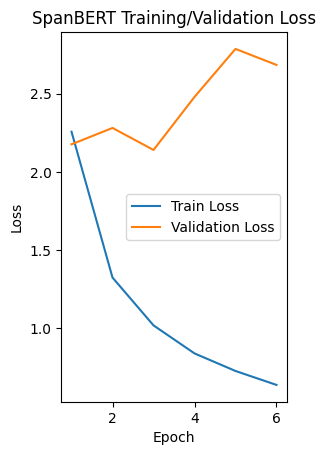

In [24]:
em_spanbert, f1_spanbert = evaluate_model(model_spanbert, val_dataloader, tokenizer, device, model_type="spanbert")
print(f"SpanBERT - Exact Match: {em_spanbert:.2f}%, F1 Score: {f1_spanbert:.2f}")
# Plot for SpanBERT
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SpanBERT Training/Validation Loss")
plt.legend()


Processing sample index: 0
Processing sample index: 100
Processing sample index: 200
Processing sample index: 300
Processing sample index: 400
Processing sample index: 500
Processing sample index: 600
Processing sample index: 700
Processing sample index: 800
Processing sample index: 900
SpanBERT-CRF - Exact Match: 18.70%, F1 Score: 0.25


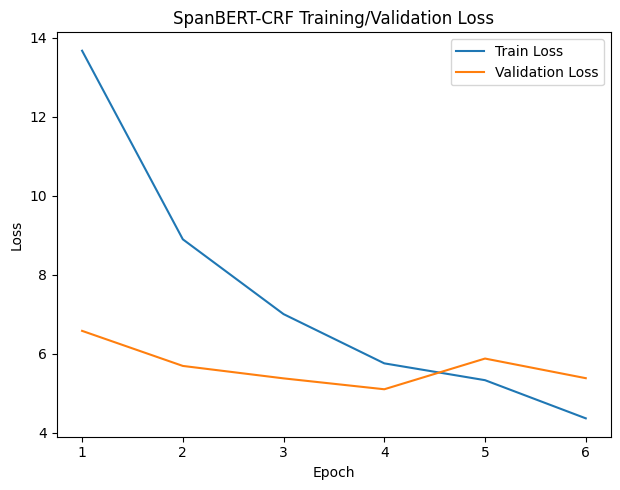

In [18]:
# Evaluate SpanBERT-CRF
em_spanbert_crf, f1_spanbert_crf = evaluate_model(model_spanbert_crf, val_dataloader, tokenizer, device, model_type="spanbert_crf")
print(f"SpanBERT-CRF - Exact Match: {em_spanbert_crf:.2f}%, F1 Score: {f1_spanbert_crf:.2f}")

# Plotting Training and Validation Loss for both models
plt.figure(figsize=(12, 5))


# Plot for SpanBERT-CRF
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_losses_crf, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses_crf, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SpanBERT-CRF Training/Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
import shutil

# Zip all output files
shutil.make_archive('/kaggle/working/all_outputs', 'zip', '/kaggle/working')

print("Zipping complete! You can now download the 'all_outputs.zip' file from the Kaggle UI.")


Zipping complete! You can now download the 'all_outputs.zip' file from the Kaggle UI.
